# 基于 服务器 IPS参数 的推荐系统 - version 20170822

1. 文章参考链接1-http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/
2. 文章参考链接2-http://blog.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/

## 背景介绍
IPS 即 Intruction per second, 记录的是当前任务所在线程所在的核“每秒钟执行的指令数”。

启动任务workload 代码示例：
- load1 代表当前workload。

注：当前所有的workloads （in SPEC CPU2006 测试集） 都是单线程任务。


cd /spec2006
source shrc
runspec --config=mytest.cfg --size=ref --noreportable --tune=base --iterations=1 "$load1" &


监控代码示例：
- load1 代表当前workload。
- pid1  代表当前workload所在的线程。

注：当前所有的workloads （in SPEC CPU2006 测试集） 都是单线程任务。


./task -t $pid1 -p -e UNHALTED_CORE_CYCLES  1> /home/xiandong-Code-Result/result/"$load1".txt &


## 测试结果收集 
在 IPS-rating-final.csv 文件中，

- 第一列代表各种 workloads ，如 workload_id=0 代表 名称为 bwaves 的workload.
- 第二列代表各种测试压力, 如 pressure_id=0 代表 CPU 压力。
- 第三列代表 （某压力下IPS／单独运行时IPS） 的百分制评分

注：当前测试的七种压力（i.e., CPU, LL3 cache, memory）均由 ibench 测试集提供。

## 为未来应用提供的便捷性：

在未来的使用中，每次任务提交时，只需在IPS-rating-final.csv文件中，继续补充 此种workload_id 的在 pressure_id 测试值（2-3次），即可得出此种 workload在每一种压力下的 “百分制评分”。 测试代码本身不需要修改，代码可以自动为 “以前未出现过的 workload 或者 压力” 添加新的行 或者 列。




## 为 jupyter notebook 载入 python 需要的库

In [1]:
import numpy as np # linear algebra
np.random.seed(0)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline  

## 载入原始数据

In [2]:
# Load data from disk

names = ['workload_id', 'pressure_id', 'rating']
df = pd.read_csv('/Users/dong/Desktop/体系-数据分析/IPS-rating-final.csv',delimiter=",", names=names)

print(df.shape)

num_workloads = df.workload_id.unique().shape[0]
num_pressures = df.pressure_id.unique().shape[0]

print(num_workloads, "kinds of workloads")
print(num_pressures, "kinds of pressures")

(86, 3)
12 kinds of workloads
8 kinds of pressures


In [3]:
df.head()

,workload_id,pressure_id,rating
0,0,0,54
1,1,0,50
2,4,0,50
3,6,0,50
4,7,0,95


In [4]:
df.tail()

,workload_id,pressure_id,rating
81,10,3,66
82,10,4,89
83,11,4,95
84,11,1,95
85,11,4,95


## 创建评分/ratings 矩阵

### 横轴-workloads
### 纵轴-pressures （各类压力）

In [5]:
# Create $r_{ui}$, our ratings matrix
ratings = np.zeros((num_workloads, num_pressures))
for row in df.itertuples():
    ratings[row[1], row[2]] = row[3]

In [6]:
print(ratings)

[[  54.   85.   54.   76.  101.  101.   95.  100.]
 [  50.   82.   50.   74.  100.   94.  100.  100.]
 [  50.   79.   50.   71.   99.   97.  100.  100.]
 [  50.   74.   50.   68.   95.   96.   96.  100.]
 [  50.   79.   50.   72.   97.   96.   98.  100.]
 [  50.   74.   50.   67.   92.   90.   94.  100.]
 [  50.   81.   49.   69.   98.   91.  101.  100.]
 [  95.   78.   52.   78.   85.   86.   95.  100.]
 [  50.   81.   50.   71.  100.   99.  100.  100.]
 [  50.   83.   50.   76.   99.   98.   99.  100.]
 [   0.    0.   50.   66.   89.    0.    0.    0.]
 [   0.   95.    0.    0.   95.    0.    0.    0.]]


### 将原评分矩阵 分为 训练矩阵 和 测试矩阵

In [7]:
# Split into training and test sets. 
# Remove 10 ratings for each workload 
# and assign them to the test set
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for workload in range(ratings.shape[0]):
        # xrange() was renamed to range() in Python 3.
        test_ratings = np.random.choice(ratings[workload, :].nonzero()[0], 
                                        size=2, 
                                        replace=False)
        train[workload, test_ratings] = 0.
        # change the original value to 0
        test[workload, test_ratings] = ratings[workload, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

train, test = train_test_split(ratings)
print("train.shape",train.shape)
print("test.shape",test.shape)

train.shape (12, 8)
test.shape (12, 8)


In [8]:
from sklearn.metrics import mean_squared_error
import math

def get_rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return math.sqrt(mean_squared_error(pred, actual))

## 编写函数 ExplicitMF

In [9]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=3,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print()
                print("current iteration:", ctr)
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print("Iteration:", n_iter)
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)
                # Train model for n_iter - iter_diff iterations.

            predictions = self.predict_all()

            self.train_mse += [get_rmse(predictions, self.ratings)]
            self.test_mse += [get_rmse(predictions, test)]
            if self._v:
                print("Train mse: ", str(self.train_mse[-1]))
                print("Test mse:", str(self.test_mse[-1]))
            iter_diff = n_iter
            if n_iter == iter_array[-1]:
                print()
                print("Prediction Result...")
                print(np.array(predictions, dtype=int))
                

## 对数据进行最终计算

In [10]:
MF_SGD = ExplicitMF(train, 3, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 8, 10, 15, 20,30,50,100]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
Train mse:  19.245534512856008
Test mse: 19.224818928472896
Iteration: 2
Train mse:  19.082915427318373
Test mse: 19.12747285301101
Iteration: 5
Train mse:  18.60059074637874
Test mse: 18.836923038675334
Iteration: 8
Train mse:  18.10209126459132
Test mse: 18.534079242269023
Iteration: 10
Train mse:  17.740399802721736
Test mse: 18.313061352676293
Iteration: 15
Train mse:  16.589562463017376
Test mse: 17.60341704236026
Iteration: 20
Train mse:  14.674725459673073
Test mse: 16.395747359042748
Iteration: 30

current iteration: 10
Train mse:  8.19833121771332
Test mse: 11.686509195178186
Iteration: 50

current iteration: 10

current iteration: 20
Train mse:  4.701754221257128
Test mse: 7.2796848741158415
Iteration: 100

current iteration: 10

current iteration: 20

current iteration: 30

current iteration: 40

current iteration: 50
Train mse:  2.43115715729785
Test mse: 6.672407438091393

Prediction Result...
[[ 53  81  52  74 100  96  99 101]
 [ 49  79  49  72  98  94  97 10

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('RMSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);


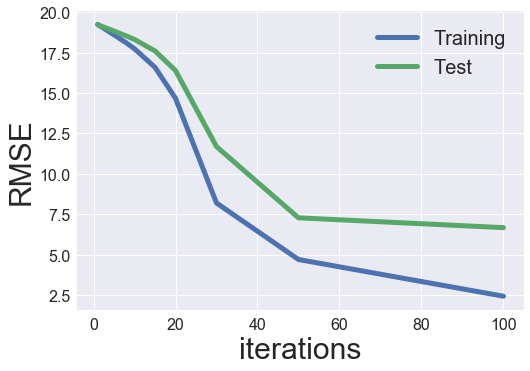

In [12]:
plot_learning_curve(iter_array, MF_SGD)

## 参数调优

Let's try to optimize some hyperparameters. We'll start with a grid search of the learning rate.

In [13]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [2, 3, 4, 5]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print("Config of 'Factors':", fact)
    for reg in regularizations:
        print("Config of 'Regularization':", reg)
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print()
            print("New optimal hyperparameters")
            print(pd.Series(best_params))

Config of 'Factors': 2
Config of 'Regularization': 0.001

Prediction Result...
[[ 52  84  57  75 100  97  97  99]
 [ 49  80  50  72  98  95  96  99]
 [ 50  78  46  71  99  95  98 101]
 [ 50  75  43  69  96  92  96 100]
 [ 50  79  49  71  98  94  96  99]
 [ 50  74  43  68  95  91  96  99]
 [ 50  77  47  70  96  93  95  98]
 [ 94  68  52  76  84  79  94  99]
 [ 49  81  50  73 100  97  99 101]
 [ 49  80  51  72  99  95  96  99]
 [ 68  82  71  78  88  86  86  88]
 [ 69  81  71  77  88  86  86  87]]

New optimal hyperparameters
model        <__main__.ExplicitMF object at 0x11fcffc50>
n_factors                                              2
n_iter                                               100
reg                                                0.001
test_mse                                         6.62123
train_mse                                        2.64966
dtype: object
Config of 'Regularization': 0.01

Prediction Result...
[[ 52  82  65  75 100  98  98  98]
 [ 50  78  50  71  98  94


Prediction Result...
[[ 54  81  55  74  98  95  98 100]
 [ 51  79  51  72  97  94  97  99]
 [ 51  79  53  72  98  94  97  99]
 [ 51  78  53  71  96  93  95  97]
 [ 52  79  51  71  97  93  97  99]
 [ 51  77  53  71  95  92  94  96]
 [ 51  78  50  71  96  93  96  98]
 [ 89  83  55  78  85  85  93  96]
 [ 51  80  54  72  99  95  98 100]
 [ 52  79  51  72  97  94  97  99]
 [ 70  80  69  77  87  86  88  88]
 [ 78  80  77  79  82  82  82  82]]


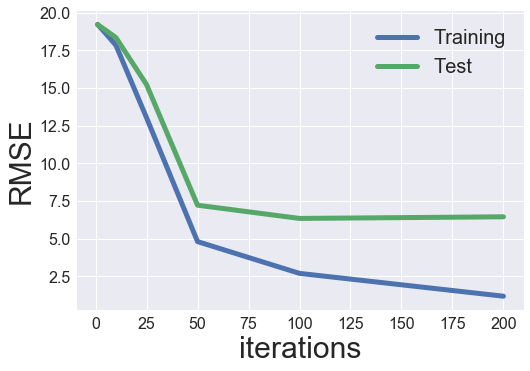

In [14]:
plot_learning_curve(iter_array, best_params['model'])

In [15]:
print("Best regularization:", best_params['reg'])
print("Best latent factors:", best_params['n_factors'])
print("Best iterations:", best_params['n_iter'])

Best regularization: 0.001
Best latent factors: 3
Best iterations: 100
